In [31]:
import ilang_fs as il

In [32]:
il.setup_project('SRN')

In [33]:
d = il.raw_data_from_CSV('raw_data/ilang_SRN_data.csv', ',') 

In [34]:
sd = il.structure_raw_data(d)

In [35]:
td = il.make_rel_net(sd, 'Definiens', 'Definiendum')

In [36]:
n_p = il.pos_by_in_degrees(td)

In [37]:
n_labels = il.format_node_labels(td, sd, 'full_name', 30, 55)

In [38]:
pos_node_labels = il.offset_node_labels(n_p, 0, 1)

In [39]:
colors = il.make_color_list(len(td.nodes()))

In [40]:
colored_nodes = il.color_nodes(td, colors, '#FFFFFF')

In [41]:
colore_edges = il.color_edge_by_target_node(td, colored_nodes)

In [42]:
# define label on all edges
edgelabels = dict()
for e in td.edges(): edgelabels[e] = 'defines'

In [30]:
def draw_rel_net(graph, node_positions, node_labels, node_colors, edge_labels, edge_colors, fig_w = 10, fig_h = 10, dpi_val = 90, fig_margin = 0.15):
    import networkx as nx
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    plt.figure(num=None, figsize=(fig_w, fig_h), dpi=dpi_val, facecolor='w')
    plt.margins(fig_margin)
    plt.axis('off')
    nx.draw_networkx_nodes(graph, node_positions, node_color = list(node_colors.values()), node_shape = 'o', node_size = 20)
    nx.draw_networkx_labels(graph, pos = pos_node_labels, labels = node_labels, font_size = 8)
    nx.draw_networkx_edges(graph, node_positions, edge_color = edge_colors)
    nx.draw_networkx_edge_labels(graph, node_positions, edge_labels = edge_labels, font_size = 8)

In [ ]:
fg = draw_rel_net(td, n_p, n_labels, colored_nodes, edgelabels)

In [ ]:
def draw_rel_net(graph, node_positions, fig_w = 10, fig_h = 10, dpi = 90, fig_margin = 0.15, ):
    import networkx as nx
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    plt.figure(num=None, figsize=(fig_w, fig_h), dpi=90, facecolor='w')
    plt.margins(0.15)
    plt.axis('off')
    nx.draw_networkx_nodes(graph, node_positions, node_color = list(colored_nodes.values()), node_shape = 'o', node_size = 100)
    nx.draw_networkx_labels(graph, pos = pos_node_labels, labels = n_labels, font_size = 8)
    nx.draw_networkx_edges(graph, node_positions, edge_color = colore_edges)
    nx.draw_networkx_edge_labels(graph, node_positions, edge_labels = edgelabels, font_size = 8)

{('Smart Retail Network software.', 'SRN'): Text(0.5,1,'defines'),
 ('Shop Display Management software.', 'SDM'): Text(0.5,21,'defines'),
 ('Object installed at a POP, which is used to promote products; Shop Display is synonym with Fixture.',
  'Shop Display'): Text(0.5,41,'defines'),
 ('A Shop Display which cannot itself be subdivided.',
  'Basic Shop Display'): Text(0.5,61,'defines'),
 ('A Shop Display made from two or more Basic Shop Displays.',
  'Complex Shop Display'): Text(0.5,81,'defines'),
 ('Unique numeric identifier generated by SDM for each BSD, used to identify a BSD when a QR code scanner is not available.',
  'Shop Display Identifier'): Text(0.5,101,'defines'),
 ('Representative of the company supplying Shop Displays.',
  'Shop Display Supplier'): Text(0.5,121,'defines'),
 ('Location (shop) where products are being sold.',
  'Point of Purchase'): Text(0.5,141,'defines'),
 ('An individual visiting a POP and collecting data about the POP; an FMR typically gets a list of PO

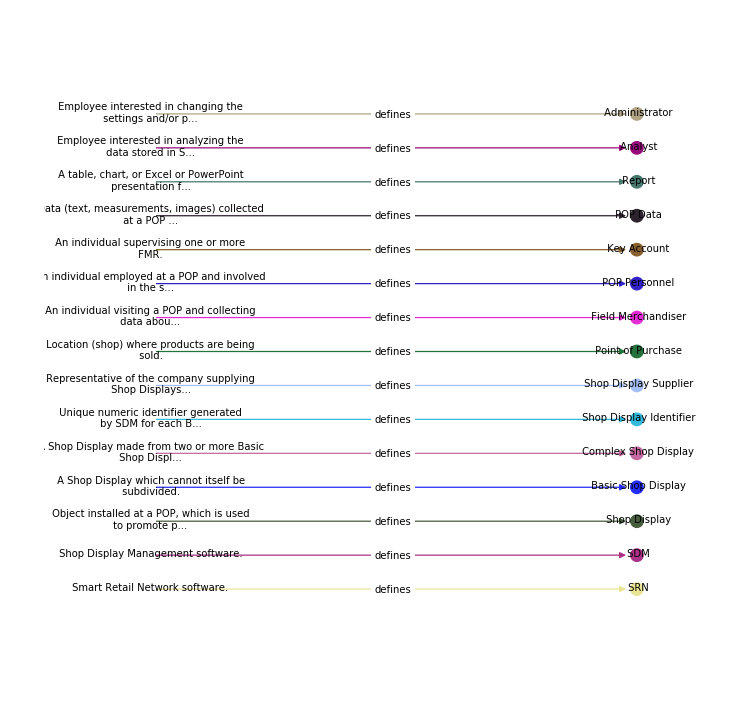

In [29]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Draw the subnet
plt.figure(num=None, figsize=(10, 10), dpi=90, facecolor='w', edgecolor='g')
plt.margins(0.15)
plt.axis('off')
# plt.grid(b = None, linestyle = 'dotted')
il.nx.draw_networkx_nodes(td, n_p, node_color = list(colored_nodes.values()), node_shape = 'o', node_size = 100)
il.nx.draw_networkx_labels(td, pos = pos_node_labels, labels = n_labels, font_size = 8)
il.nx.draw_networkx_edges(td, n_p, edge_color = colore_edges)
il.nx.draw_networkx_edge_labels(td, n_p, edge_labels = edgelabels, font_size = 8)

# nx.draw(td, pos, node_list = your_subgraph.nodes(), edgelist = your_subgraph.edges(), 
#         labels = node_labels_short, arrows=True, with_labels=True, 
#         node_color = node_colors_list, edge_color = edge_colors_list)

# # Save image as PNG file.
# image_file_name = "%s_Subgraph_%s.png" % (analysis_project_name, filename_suffix)
# plt.savefig(image_file_name)
# print('Sub-network image filename:', image_file_name)